# Importações

In [35]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, KFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import DataConversionWarning
from sklearn.neighbors import KNeighborsRegressor
from pyod.models.knn import KNN

# Remover alertas
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# Carregar dados
Os arquivos CSV com os dados das APAC foram carregados e então alguns registros foram visualizados para verificar se a importação ocorreu de forma correta.   
Nesse estudo a variável dependente será a `tempo_autorizacao` e as demais serão utilizadas para predição.

In [36]:
# Carregar os dados
df = pd.read_csv('dados_sc.csv')    

# Visualizar o formato do dataset 
print(f'Linhas (registros): {df.shape[0]} | Colunas (variáveis): {df.shape[1]}')

Linhas (registros): 117356 | Colunas (variáveis): 12


# Pré-processamento

## Validar dados

## Excluir variáveis não utilizadas
Primeiramente, foi verificado que as colunas `cns_paciente` e `cns_paciente` não possuem utilidade para a criação do modelo e as mesmas foram excluídas. 

In [37]:
# Excluir as variáveis
df.drop('cns_paciente', inplace=True, axis=1)
df.drop('paciente_novo', inplace=True, axis=1)

# Confirmar a exclusão das colunas
df.head()

,procedimento,cid,idade_paciente,sexo_paciente,municipio_residencia_paciente,cnes_solicitante,data_solicitacao,data_autorizacao,competencia_dispensacao,tempo_autorizacao
0,604780010,E101,14,M,420700,0,2022-01-04,2022-01-04,2022-01-01,0
1,604800010,D688,40,F,421580,0,2022-01-03,2022-01-13,2022-01-01,10
2,604550022,G518,60,F,420890,0,2022-01-04,2022-01-04,2022-01-01,0
3,604550014,G513,68,F,421820,0,2022-01-27,2022-01-27,2022-01-01,0
4,604550022,G518,49,F,420730,0,2022-01-04,2022-01-04,2022-01-01,0


### Dados nulos
Foi verificado que a base de dados não possui valores nulos. 

In [38]:
# Verificar a existência de dados nulos
qtd_nulos = df.isnull().sum()
print(qtd_nulos)

procedimento                     0
cid                              0
idade_paciente                   0
sexo_paciente                    0
municipio_residencia_paciente    0
cnes_solicitante                 0
data_solicitacao                 0
data_autorizacao                 0
competencia_dispensacao          0
tempo_autorizacao                0
dtype: int64


### CNES solicitante
Foram avaliados os dados estatísticos de cada variável. Foi constatado que a coluna `cnes_solicitante` possui o mesmo valor `0000000` para todos os registros. Os dados da referida coluna foram plotados em um bloxplot para confirmar a avaliação inicial. Dessa forma, a coluna `cnes_solicitante` foi excluída.

In [39]:
# Consultar informações das colunas
df.describe()

,procedimento,idade_paciente,municipio_residencia_paciente,cnes_solicitante,tempo_autorizacao
count,1.173560e+05,117356.000000,117356.000000,117356.0,117356.000000
mean,6.043895e+08,52.370497,420874.017178,0.0,18.888996
std,2.520460e+05,20.327221,1357.196554,0.0,22.521774
min,6.040100e+08,0.000000,330320.000000,0.0,0.000000
25%,6.042300e+08,39.000000,420430.000000,0.0,3.000000
50%,6.043600e+08,56.000000,420850.000000,0.0,11.000000
75%,6.045500e+08,68.000000,421280.000000,0.0,27.000000
max,6.048500e+08,103.000000,431490.000000,0.0,218.000000


<Axes: >

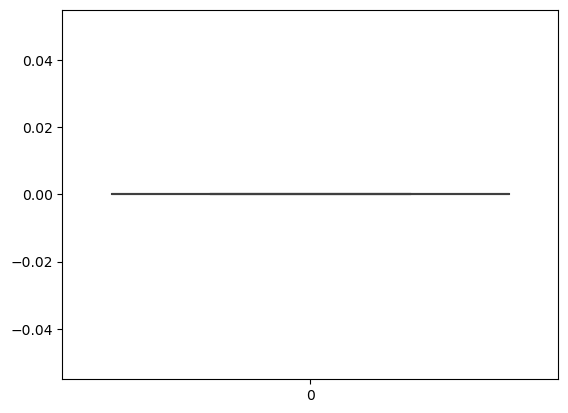

In [40]:
# Confirmar que a coluna cnes_solicitante possui dados inválidos
sns.boxplot(df['cnes_solicitante'])

In [41]:
# Excluir a coluna 'cnes_solicitante'
df.drop('cnes_solicitante', inplace=True, axis=1)

# Confirmar a exclusão
df.head()

,procedimento,cid,idade_paciente,sexo_paciente,municipio_residencia_paciente,data_solicitacao,data_autorizacao,competencia_dispensacao,tempo_autorizacao
0,604780010,E101,14,M,420700,2022-01-04,2022-01-04,2022-01-01,0
1,604800010,D688,40,F,421580,2022-01-03,2022-01-13,2022-01-01,10
2,604550022,G518,60,F,420890,2022-01-04,2022-01-04,2022-01-01,0
3,604550014,G513,68,F,421820,2022-01-27,2022-01-27,2022-01-01,0
4,604550022,G518,49,F,420730,2022-01-04,2022-01-04,2022-01-01,0


### CID-10
Foi verificado se o campo `cid` possui todos os registros dentro do padrão abaixo:   
1- Máximo quatro caracteres;  
2- Começar com letra;  
3- Terminar com três dígitos.

In [42]:
# Padrão do CID-10 em regex
padrao_cid = r'^[a-zA-Z][0-9]{3}$|^[a-zA-Z][0-9]{2}$'

# Retirar os espaços
df['cid'] = df['cid'].str.strip()

# Filtrar os registros que não atendem ao regex
cid_invalidos = ~df['cid'].str.contains(padrao_cid)

# Imprimir os registros que não atendem ao regex
print("Total de CID-10 inválidos: ", len(df[cid_invalidos]))

Total de CID-10 inválidos:  0


### Idade paciente
Na avalição da idade dos paciente não foram encontrados valores negativos ou acima do aceitável.

(array([ 4715.,  6630.,  8353., 13096., 15872., 22563., 28348., 14148.,
         3472.,   159.]),
 array([  0. ,  10.3,  20.6,  30.9,  41.2,  51.5,  61.8,  72.1,  82.4,
         92.7, 103. ]),
 <BarContainer object of 10 artists>)

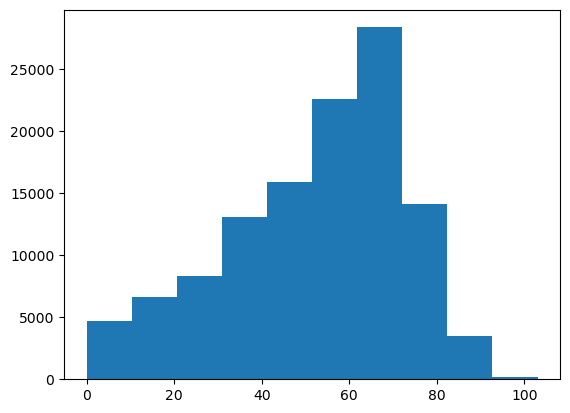

In [43]:
# Plotar histograma da coluna 'idade_paciente'
plt.hist(df['idade_paciente'])

Foi plotado um gráfico de distribuiçao entre a idade e o tempo de autorização para verificar se existe alguma correlação linear, haja vista que a idade é a única variável numérica do dataframe. Contudo, não foi observada nenhuma correlação.

<Axes: xlabel='idade_paciente', ylabel='tempo_autorizacao'>

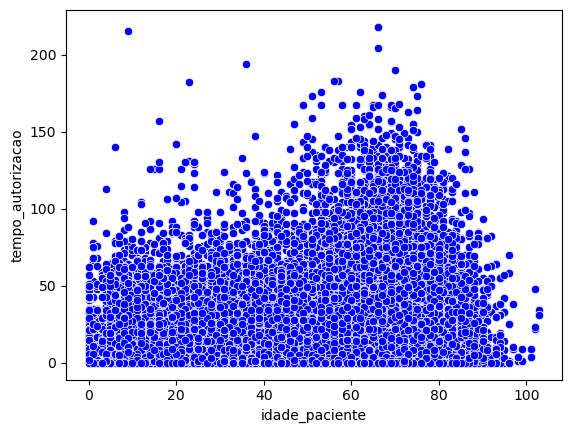

In [44]:
# Plotar gráfico de distribuição com os atributos 'idade_paciente' e 'tempo_autorizacao'
sns.scatterplot(data= df, x=df['idade_paciente'], y='tempo_autorizacao', color='blue')

### Município de residência do paciente
Posteriormente, foi avaliada a qualidade dos dados da coluna `municipio_residencia_paciente`. O estado de Santa Catarina possui 295 município e 137.699 pacientes distintos do estado realizam solicitação de medicamentos do CEAF em 2022. Dessa forma, é esperado que grande parte dos municípios tenham ao menos um residente que solicitou algum medicamento do CEAF.

In [45]:
# Contar a quantidade distinta de municípios
total_municipios = df['municipio_residencia_paciente'].nunique()
print("Total de municípios de residência distintos que foram atendidos em Santa Catarina: ",total_municipios)

Total de municípios de residência distintos que foram atendidos em Santa Catarina:  305


Foi verificado que pacientes residentes de municípios fora de Santa Catarina solicitaram medicamentos na UF, pois 310 municípios distintos foram retornados.

In [46]:
# Contar os municípios não Catarinenses
selecao = df.loc[(~df['municipio_residencia_paciente'].astype(str).str.startswith('42'))]
print("Total de municípios fora de Santa Catarina: ", selecao['municipio_residencia_paciente'].nunique())

Total de municípios fora de Santa Catarina:  10


O marco regulatório do CEAF não proíbe o atendimento de pacientes de outros estados ou estrangeiros. Assim, verificou-se que todos os 295 municípios (310 - 15) do estado tiveram ao menos um paciente que solicitou medicamento do CEAF em 2022.

### Sexo paciente
Foi verificado se a variável `sexo_paciente` possui algum valor fora do previsto (F ou M), de acordo o padrão do SIA/SUS .   
Conforme apresentado abaixo todos os registros possuem dados válidos.

In [47]:
# Contar a quantidade de registros por valor distinto
df['sexo_paciente'].value_counts()

F    66599
M    50757
Name: sexo_paciente, dtype: int64

### Data de solicitação e autorização
As colunas `data_solicitacao` e `data_autorizacao` também foram avaliadas. Primeiramente, os campos `data_solicitacao` e `data_autorizacao` foram transformados para o tipo `datetime64`, onde verificou-se que todos os registros possuem datas válidas.

In [48]:
# Transformar os campos 'data_solicitacao' e 'data_autorizacao' para o formato de data
df['data_solicitacao'] = pd.to_datetime(df['data_solicitacao'], format='%Y-%m-%d')
df['data_autorizacao'] = pd.to_datetime(df['data_autorizacao'], format='%Y-%m-%d')

# Visualizar o novo formato dos campos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117356 entries, 0 to 117355
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   procedimento                   117356 non-null  int64         
 1   cid                            117356 non-null  object        
 2   idade_paciente                 117356 non-null  int64         
 3   sexo_paciente                  117356 non-null  object        
 4   municipio_residencia_paciente  117356 non-null  int64         
 5   data_solicitacao               117356 non-null  datetime64[ns]
 6   data_autorizacao               117356 non-null  datetime64[ns]
 7   competencia_dispensacao        117356 non-null  object        
 8   tempo_autorizacao              117356 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 8.1+ MB


Posteriormente, foi verificado que os campos não possuem outliers ao plotar um gráfico com a quantidade de registros por data de solicitação ou avaliação.

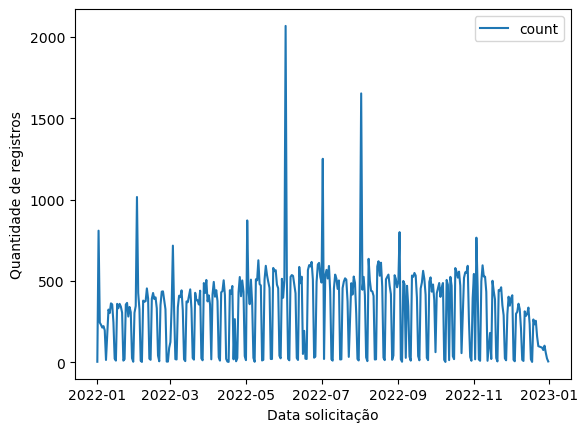

In [49]:
# Plotar a quantidade de registros por data da coluna 'data_solicitacao'
df_count = df.groupby(df['data_solicitacao'].dt.date).size().reset_index(name='count')
df_count.plot(x='data_solicitacao', y='count')
plt.xlabel('Data solicitação')
plt.ylabel('Quantidade de registros')
plt.show()

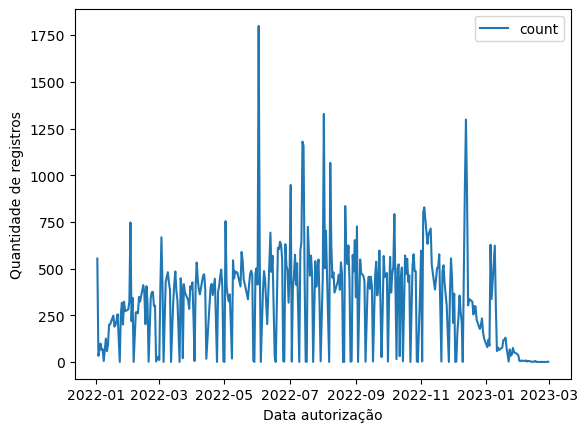

In [50]:
# Plotar a quantidade de registros por data da coluna 'data_autorizacao'
df_count = df.groupby(df['data_autorizacao'].dt.date).size().reset_index(name='count')
df_count.plot(x='data_autorizacao', y='count')
plt.xlabel('Data autorização')
plt.ylabel('Quantidade de registros')
plt.show()

Adicionalmente, foi preciso verificar se algum registro possuía uma data de autorização anterior a data de solicitação, pois isso não deve ocorrer.

In [51]:
# Contar a quantidade de registros que possuem a data de autorização inferior a data de autorização
qtd_invalido = (df['data_autorizacao'] < df['data_solicitacao']).sum()
print("Total de registros com a data de autorização inferior a data de solicitação: ", qtd_invalido)

Total de registros com a data de autorização inferior a data de solicitação:  0


### Competência de dispensação
O SIA/SUS não disponibiliza a data exata das dispensações, somente o mês e ano. Por isso, todos os registros possuem o primeiro dia do mês como data de dispensação. Assim, os dados foram transformados para o tipo `datetime64`, onde verificou-se que todos os registros possuem datas válidas.

In [52]:
# Transformar o campos 'competencia_dispensacao' para o formato de data
df['competencia_dispensacao'] = pd.to_datetime(df['competencia_dispensacao'], format='%Y-%m-%d')

# Confirmar a atualização
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117356 entries, 0 to 117355
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   procedimento                   117356 non-null  int64         
 1   cid                            117356 non-null  object        
 2   idade_paciente                 117356 non-null  int64         
 3   sexo_paciente                  117356 non-null  object        
 4   municipio_residencia_paciente  117356 non-null  int64         
 5   data_solicitacao               117356 non-null  datetime64[ns]
 6   data_autorizacao               117356 non-null  datetime64[ns]
 7   competencia_dispensacao        117356 non-null  datetime64[ns]
 8   tempo_autorizacao              117356 non-null  int64         
dtypes: datetime64[ns](3), int64(4), object(2)
memory usage: 8.1+ MB


Posteriormente, foi verificado que o campo não possui outliers ao plotar um gráfico com a quantidade de registros por data de dispensação.

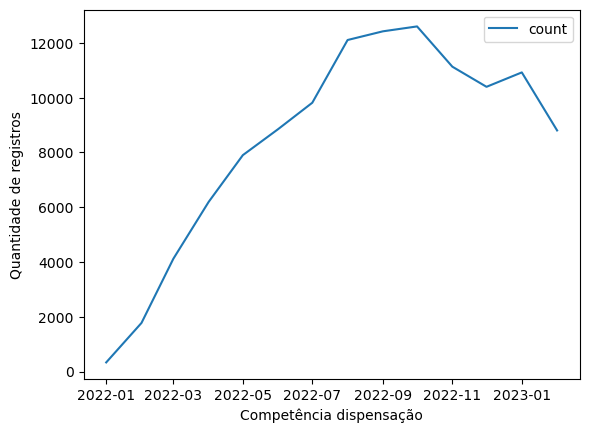

In [53]:
# Plotar a quantidade de registros por data da coluna 'data_autorizacao'
df_count = df.groupby(df['competencia_dispensacao'].dt.date).size().reset_index(name='count')
df_count.plot(x='competencia_dispensacao', y='count')
plt.xlabel('Competência dispensação')
plt.ylabel('Quantidade de registros')
plt.show()

Por fim, foi verificado que existe um registro contendo a competência de dispensação anterior a data de autorização. Dessa forma, o respectivo registro foi excluído.

In [54]:
# Verificar registros que possuem a competência de dispensação anterior a data de autorização
registros_invalidos = df['competencia_dispensacao'].dt.to_period('M') < df['data_autorizacao'].dt.to_period('M')

# Visualizar os registros localizados
df[registros_invalidos]

,procedimento,cid,idade_paciente,sexo_paciente,municipio_residencia_paciente,data_solicitacao,data_autorizacao,competencia_dispensacao,tempo_autorizacao
69004,604010036,K512,39,F,420360,2022-05-04,2022-07-01,2022-06-01,58


In [55]:
# Excluir os registros com inconsistência entre as colunas 'competencia_dispensacao' e 'data_autorizacao'
df = df.loc[~registros_invalidos]

# Confirmar que a exclusão ocorreu 
df.shape

(117355, 9)

### Tempo autorização
Primeiramente foi plotado um bolxplot para verificar se a variável dependente possui algum outlier. No bloxplot pode-se verificar uma grande quantidade de outliers.   
Foi observado que a mediana está consideravelmente mais próxima do primeiro quartil do que do terceiro, devido a grande quantidade de valores zerados. Isso fez com que 5563 registros fossem classificados como outliers no bloxplot. Assim, é necessário empregar outro algoritmo para detectar os outliers.

count    117355.000000
mean         18.888663
std          22.521580
min           0.000000
25%           3.000000
50%          11.000000
75%          27.000000
max         218.000000
Name: tempo_autorizacao, dtype: float64


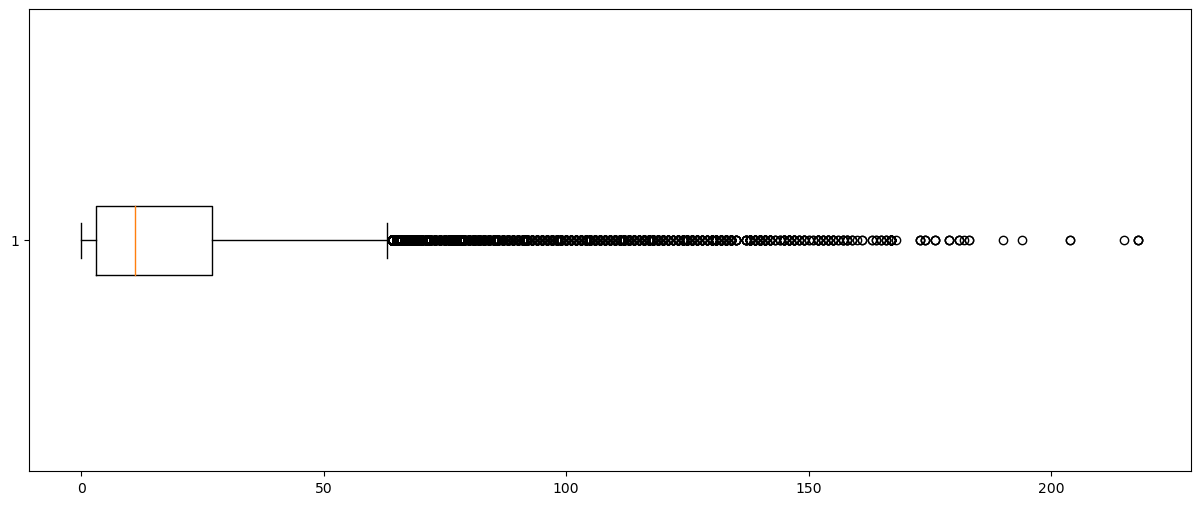

In [56]:
# Plotar boxplot
fig, ax = plt.subplots(figsize=(15,6))
ax.boxplot(df['tempo_autorizacao'], vert=False)

# Visualizar dados estatísticos da coluna
print(df['tempo_autorizacao'].describe())

In [57]:
# Extrair a quantidade de registros considerados outliers
sumario = df['tempo_autorizacao'].describe()
q1 = sumario["25%"]
q3 = sumario["75%"]
iqr = q3 - q1
outliers = df[(df['tempo_autorizacao'] < q1 - 1.5 * iqr) | (df['tempo_autorizacao'] > q3 + 1.5 * iqr)]

# Visualizar a quantidade de outliers
print("Quantidade de outliers:", len(outliers))

Quantidade de outliers: 5563


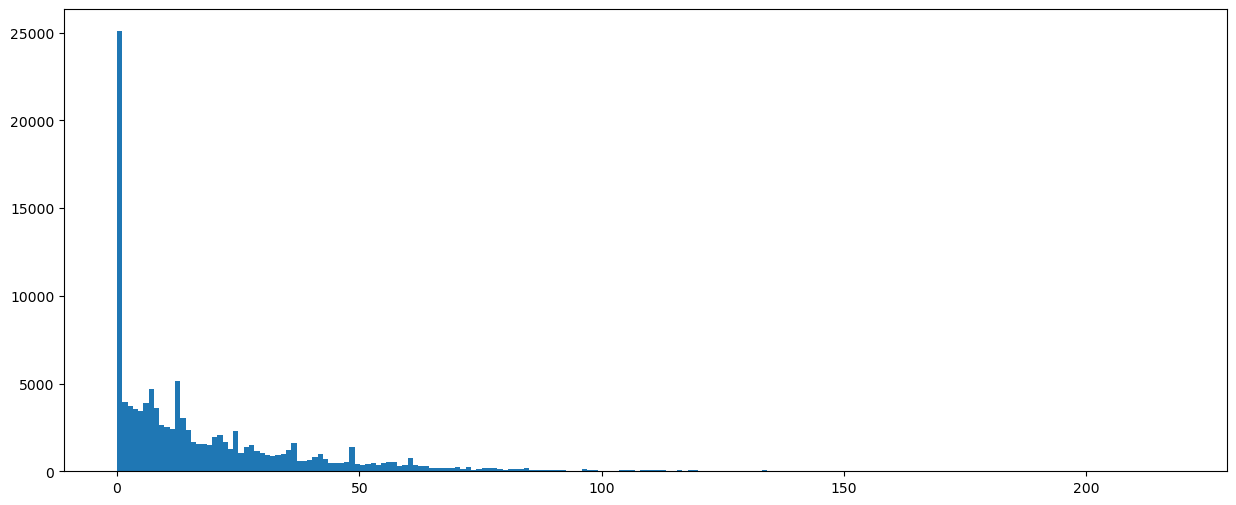

In [58]:
# Visualizar o histograma da coluna 'tempo_autorizacao'
fig, ax = plt.subplots(figsize=(15,6))
ax.hist(df["tempo_autorizacao"], bins=200)
plt.show()

Foi utilizado o algoritmo KNN para detecção dos outliers. Ao contrário do boxplot, o KNN leva em consideração as outras variáveis do dataframe para determinar os outliers. O KNN classificou 72 registros como outliers, e estes foram excluídos do dataframe.

In [59]:
# Instanciar o modelo KNN
preditor = KNN()

# Selecioanr a coluna de interesse
df_sel = df[['tempo_autorizacao']]

# Treinar o modelo
preditor.fit(df_sel)
outliers = preditor.labels_

# Contar os outliers
resultado = np.unique(outliers, return_counts=True)
print("Total de outliers:", resultado[1][1])

# Excluir do dataframe as linhas que foram classificadas como outlier
for i in range(len(outliers)):
        if outliers[i] == 1:
            df = df.drop(i)

# Registros no dataframe
print("Total de registros no dataframe:", len(df))

Total de outliers: 72
Total de registros no dataframe: 117283


## Transformar variáveis

### Variáveis temporais
O primeiro tramamento realizado foi para as três colunas do tipo data, `data_solicitacao`, `data_autorizacao` e `competencia_dispensacao`, onde os dados foram extratificados em novas colunas contendo o ano, mês, semana e dia.   
A única exceção foi para a coluna `competencia_dispensacao` que possui todos os seus registros com o primeiro dia de cada mês. Dessa forma, não foram criadas colunas para a semana e dia.

In [60]:
# Transformar a coluna 'data_solicitacao'
df['data_solicitacao_ano'] = df['data_solicitacao'].dt.year
df['data_solicitacao_mes'] = df['data_solicitacao'].dt.month
df['data_solicitacao_semana'] = df['data_solicitacao'].dt.week
df['data_solicitacao_dia'] = df['data_solicitacao'].dt.day

# Transformar a coluna 'data_autorizacao'
df['data_autorizacao_ano'] = df['data_autorizacao'].dt.year
df['data_autorizacao_mes'] = df['data_autorizacao'].dt.month
df['data_autorizacao_semana'] = df['data_autorizacao'].dt.week
df['data_autorizacao_dia'] = df['data_autorizacao'].dt.day

# Transformar a coluna 'competencia_dispensacao'
df['competencia_dispensacao_ano'] = df['competencia_dispensacao'].dt.year
df['competencia_dispensacao_mes'] = df['competencia_dispensacao'].dt.month

# Excluir as colunas originais de data
df.drop('data_solicitacao', inplace=True, axis=1)
df.drop('data_autorizacao', inplace=True, axis=1)
df.drop('competencia_dispensacao', inplace=True, axis=1)

# Visualizar as novas colunas
df.head()

,procedimento,cid,idade_paciente,sexo_paciente,municipio_residencia_paciente,tempo_autorizacao,data_solicitacao_ano,data_solicitacao_mes,data_solicitacao_semana,data_solicitacao_dia,data_autorizacao_ano,data_autorizacao_mes,data_autorizacao_semana,data_autorizacao_dia,competencia_dispensacao_ano,competencia_dispensacao_mes
0,604780010,E101,14,M,420700,0,2022,1,1,4,2022,1,1,4,2022,1
1,604800010,D688,40,F,421580,10,2022,1,1,3,2022,1,2,13,2022,1
2,604550022,G518,60,F,420890,0,2022,1,1,4,2022,1,1,4,2022,1
3,604550014,G513,68,F,421820,0,2022,1,4,27,2022,1,4,27,2022,1
4,604550022,G518,49,F,420730,0,2022,1,1,4,2022,1,1,4,2022,1


Foi verificado se as novas colunas referentes aos anos possuem valores distintos. 

In [61]:
# Verificar as quantidades de valores distintos
quantidade_valores_distintos = df['data_solicitacao_ano'].nunique()
print(f"A coluna data_solicitacao_ano possui {df['data_solicitacao_ano'].nunique()} valores distintos.")
quantidade_valores_distintos = df['data_autorizacao_ano'].nunique()
print(f"A coluna data_autorizacao_ano possui {df['data_autorizacao_ano'].nunique()} valores distintos.")
quantidade_valores_distintos = df['competencia_dispensacao_ano'].nunique()
print(f"A coluna competencia_dispensacao_ano possui {df['competencia_dispensacao_ano'].nunique()} valores distintos.")

A coluna data_solicitacao_ano possui 1 valores distintos.
A coluna data_autorizacao_ano possui 2 valores distintos.
A coluna competencia_dispensacao_ano possui 2 valores distintos.


A variável `data_solicitacao_ano` possui apenas um valor, e por isso será excluída do modelo.

In [62]:
# Excluir coluna com somente um valor
df.drop('data_solicitacao_ano', inplace=True, axis=1)

# Confirmar a exclusão
df.head()

,procedimento,cid,idade_paciente,sexo_paciente,municipio_residencia_paciente,tempo_autorizacao,data_solicitacao_mes,data_solicitacao_semana,data_solicitacao_dia,data_autorizacao_ano,data_autorizacao_mes,data_autorizacao_semana,data_autorizacao_dia,competencia_dispensacao_ano,competencia_dispensacao_mes
0,604780010,E101,14,M,420700,0,1,1,4,2022,1,1,4,2022,1
1,604800010,D688,40,F,421580,10,1,1,3,2022,1,2,13,2022,1
2,604550022,G518,60,F,420890,0,1,1,4,2022,1,1,4,2022,1
3,604550014,G513,68,F,421820,0,1,4,27,2022,1,4,27,2022,1
4,604550022,G518,49,F,420730,0,1,1,4,2022,1,1,4,2022,1


### Variáveis categóricas
As variáveis categóricas `procedimento`, `cid`, `sexo_paciente` e `municipio_residencia_paciente` não possuem ordem de grandeza entre os seus valores. Dessa forma, é preferível utilizar o One-Hot Enconding.   
Contudo, ao avaliar os valores contidos nas colunas foi verificado que o dataframe ficaria com mais de 800 colunas ao utilizar o One-Hot Enconding, gerando um grande custo computacional para a validação cruzada aninhada.  Por isso, o One-Hot Enconding foi aplicado apenas para a variável `sexo_paciente`, pois ela possui apenas dois valores distintos. Para as demais colunas foi aplicado o Label Enconding.   

In [63]:
# Consultar os valores distintos em cada coluna
print(f"A coluna procedimento possui {df['procedimento'].nunique()} valores distintos.")
print(f"A coluna cid possui {df['cid'].nunique()} valores distintos.")
print(f"A coluna sexo_paciente possui {df['sexo_paciente'].nunique()} valores distintos.")
print(f"A coluna municipio_residencia_paciente possui {df['municipio_residencia_paciente'].nunique()} valores distintos.")

A coluna procedimento possui 235 valores distintos.
A coluna cid possui 287 valores distintos.
A coluna sexo_paciente possui 2 valores distintos.
A coluna municipio_residencia_paciente possui 305 valores distintos.


In [64]:
# Aplicar One-Hot Encoding na coluna 'sexo_paciente'
one_hot_sexo_paciente = pd.get_dummies(df['sexo_paciente'])
df = df.join(one_hot_sexo_paciente)
# Excluir as colunas originais contendo variaveis categóricas
df.drop('sexo_paciente', inplace=True, axis=1)

# Instanciar o LabelEncoder
le = LabelEncoder()
# Aplicar Label Encondingna coluna 'procedimento'
df['procedimento'] = le.fit_transform(df['procedimento'])
# Aplicar Label Enconding na coluna 'cid'
df['cid'] = le.fit_transform(df['cid'])
# Aplicar Label Enconding na coluna 'municipio_residencia_paciente'
df['municipio_residencia_paciente'] = le.fit_transform(df['municipio_residencia_paciente'])

# Visualizar o dataframe
df.head()

,procedimento,cid,idade_paciente,municipio_residencia_paciente,tempo_autorizacao,data_solicitacao_mes,data_solicitacao_semana,data_solicitacao_dia,data_autorizacao_ano,data_autorizacao_mes,data_autorizacao_semana,data_autorizacao_dia,competencia_dispensacao_ano,competencia_dispensacao_mes,F,M
0,222,34,14,116,0,1,1,4,2022,1,1,4,2022,1,0,1
1,225,18,40,245,10,1,1,3,2022,1,2,13,2022,1,1,0
2,178,132,60,141,0,1,1,4,2022,1,1,4,2022,1,1,0
3,177,131,68,277,0,1,4,27,2022,1,4,27,2022,1,1,0
4,178,132,49,119,0,1,1,4,2022,1,1,4,2022,1,1,0


### Escalonamento
Para o escalonamento das variveis numéricas foi utilizada técnica de padronização, utilizando a função `StandardScaler`. O escalonamento foi incluído no pipeline do pré-processamento.

## Correlação
Foi verificado que existe correlação nas variáveis referentes as datas de solicitação e autorização, o que sugere redundância e possibilidade de redução da dimensionalidade do dataframe. Também foi verificada forte correlação negativa entre as colunas contendo os sexos.

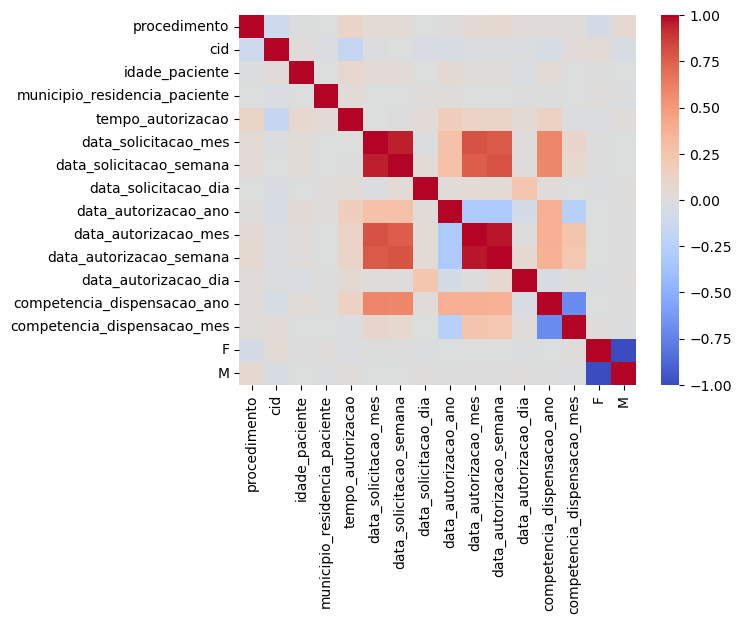

In [65]:
# Calcular a matriz de correlação
corr_matrix = df.corr()

# Gerar o mapa de calor
sns.heatmap(corr_matrix, cmap='coolwarm')

# Plotar o mapa de calor
plt.show()

## Reduzir dimensionalidade
Tendo em vista a correlação entre algumas variáveis do modelo, foi aplicada a redução da dimensionalidade no pipeline com o algoritmo `PCA`. Foi verificado que ao reduzir a dimensionalidade para 10 variáveis o RMSE aumentou consideravelmente. Tendo em vista esse impacto e o fato do modelo possuir poucas variáveis, o que não gera um grande custo computacional, a redução da dimensionalidade com o `PCA` foi excluída.   
Por fim, optou-se em excluir as colunas que apresentam forte correlação, conforme abaixo:
- data_solicitacao_mes (excluído) x data_solicitacao_semana;   
- data_autorizacao_mes (excluído) x data_autorizacao_semana;   
- F (excluído) x M.

In [66]:
# Excluir colunas com forte correlação
df.drop('data_solicitacao_mes', inplace=True, axis=1)
df.drop('data_autorizacao_mes', inplace=True, axis=1)
df.drop('F', inplace=True, axis=1)

# Confirmar a exclusão
df.head()

,procedimento,cid,idade_paciente,municipio_residencia_paciente,tempo_autorizacao,data_solicitacao_semana,data_solicitacao_dia,data_autorizacao_ano,data_autorizacao_semana,data_autorizacao_dia,competencia_dispensacao_ano,competencia_dispensacao_mes,M
0,222,34,14,116,0,1,4,2022,1,4,2022,1,1
1,225,18,40,245,10,1,3,2022,2,13,2022,1,0
2,178,132,60,141,0,1,4,2022,1,4,2022,1,0
3,177,131,68,277,0,4,27,2022,4,27,2022,1,0
4,178,132,49,119,0,1,4,2022,1,4,2022,1,0


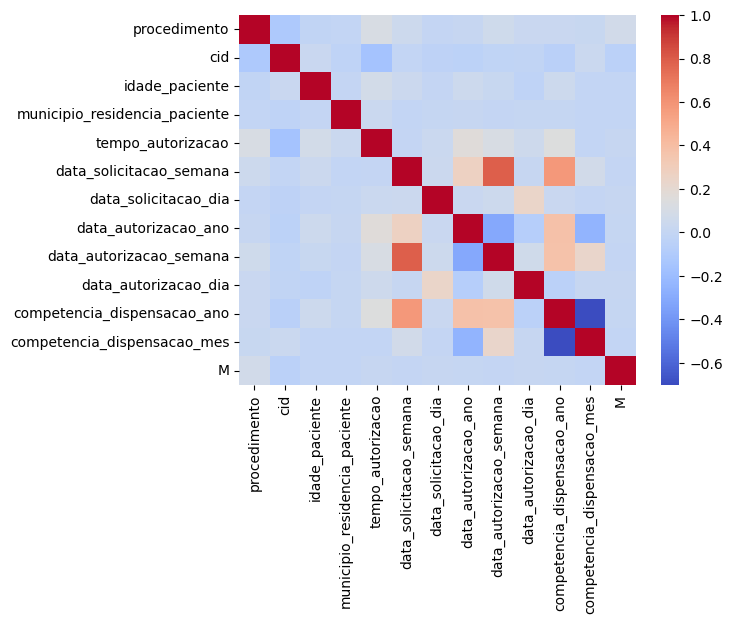

In [67]:
# Calcular a matriz de correlação
corr_matrix = df.corr()

# Gerar o mapa de calor
sns.heatmap(corr_matrix, cmap='coolwarm')

# Plotar o mapa de calor
plt.show()

## Dividir previsores e classe
O dataframe foi dividido em dois, sendo que um deles receberá as variáveis previsoras e outra receberá a classe.

In [68]:
# Dataframe com os previsores
X = df.drop("tempo_autorizacao", axis=1)

# Dataframe com a classe
y = df[["tempo_autorizacao"]].copy()

# Confirmar a criação dos dataframes
print(X.shape)
print(y.shape)

(117283, 12)
(117283, 1)


# Selecionar melhor modelo

## Pipeline
Foi criado um pipeline para realizar de forma aninhada as seguintes etapas:
- Padronizar as variáveis para que a diferença das escalas não afete o modelo;
- Criar o modelo a partir da seleção dos melhores paramêtros para cada algoritmo, utilizando o `GridSearchCV`;
- Realizar validação cruzada interna e externa (aninhada) para melhorar a generalização do modelo e reduir viés e a possíbilidade de overfiting;   
- Repetir todo o processo 3 vezes devido a característica estocástica do processo.   
   
## Resultado
Foi verificado que o melhor algoritmo para prever o tempo de atendimento dos medicamentos do CEAF foram as Redes Neurais Artificiais, pois apresentou o menor RMSE.

In [69]:
# Quantidade de partes para validação cruzada
k_cv_interno = 10
k_cv_externo = 10

# Repetições da validação cruzada aninhada
repetir_processo = 3

### Regressão linear

In [70]:
# Hora início processo
horario_inicio = time.time()

# Pipeline com os parâmetros do modelo
modelo = Pipeline([
    ("padronizacao", StandardScaler()),
    # Removido, conforme explanado anteriormente
    # ('pca', PCA(n_components=10)), 
    ("lin_reg", LinearRegression())
])  

# Hiperparâmetros para teste
parametros = {
    'lin_reg__fit_intercept':[True,False], 
    'lin_reg__copy_X':[True, False]
    }

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_regressao_linear = GridSearchCV(modelo, parametros, scoring='neg_mean_squared_error', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_regressao_linear = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_regressao_linear, X, y, cv=cv_externo, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False), n_jobs=-1)

    rmse = np.mean(scores['test_score'])*-1
    desvio_pad = np.std(scores['test_score'])
    resultado_regressao_linear.append(rmse)

    horario_fim_loop = time.time()
    tempo_total_loop = horario_fim_loop - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"RMSE {i+1}: {round(rmse,3)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média RMSE: {round(np.mean(resultado_regressao_linear),3)} ({round(np.std(resultado_regressao_linear),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

RMSE 1: 13.849 (0.886) 8s]
RMSE 2: 13.851 (0.76) 6s]
RMSE 3: 13.859 (0.521) 6s]
Média RMSE: 13.853 (0.004)
Tempo total: 0m21s


### Random Forest

In [71]:
# Hora início processo
horario_inicio = time.time()

# Pipeline com os parâmetros do modelo
pipeline = Pipeline([
    ("padronizacao", StandardScaler()),
    # Removido, conforme explanado anteriormente
    # ('pca', PCA(n_components=10)), 
    ("rf", RandomForestRegressor(random_state=1))
])  

# Hiperparâmetros para teste
parametros = {
    'rf__n_estimators': [10, 50, 100], 
    'rf__max_depth': [5, 10, 20, None]
    }

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_random_forest = GridSearchCV(pipeline, parametros, scoring='neg_mean_squared_error', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_random_forest = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_random_forest, X, y.values.ravel(), cv=cv_externo, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False), n_jobs=-1)
    
    rmse = np.mean(scores['test_score'])*-1
    desvio_pad = np.std(scores['test_score'])
    resultado_random_forest.append(rmse)

    tempo_total_loop = time.time() - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"RMSE {i+1}: {round(rmse,3)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média RMSE: {round(np.mean(resultado_random_forest),3)} ({round(np.std(resultado_random_forest),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

RMSE 1: 0.691 (0.104) 25s]
RMSE 2: 0.688 (0.119) 58s]
RMSE 3: 0.666 (0.135) 14s]
Média RMSE: 0.681 (0.011)
Tempo total: 230m37s


### KNN

In [74]:
# Hora início processo
horario_inicio = time.time()

# Pipeline com os parâmetros do modelo
pipeline = Pipeline([
    ("padronizacao", StandardScaler()),
    # Removido, conforme explanado anteriormente
    # ('pca', PCA(n_components=10)), 
    ("knn", KNeighborsRegressor())
])  

# Hiperparâmetros para teste
parametros = {
        'knn__n_neighbors': [3, 5, 10, 20],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']
        }

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_knn = GridSearchCV(pipeline, parametros, scoring='neg_mean_squared_error', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_knn = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_knn, X, y.values.ravel(), cv=cv_externo, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False), n_jobs=-1)
    
    rmse = np.mean(scores['test_score'])*-1
    desvio_pad = np.std(scores['test_score'])
    resultado_knn.append(rmse)

    tempo_total_loop = time.time() - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"RMSE {i+1}: {round(rmse,3)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média RMSE: {round(np.mean(resultado_knn),3)} ({round(np.std(resultado_knn),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

RMSE 1: 7.177 (0.091) 53s]
RMSE 2: 7.225 (0.163) 23s]
RMSE 3: 7.14 (0.194) 32s]
Média RMSE: 7.181 (0.035)
Tempo total: 63m47s


### Redes Neurais

In [100]:
# Hora início processo
horario_inicio = time.time()

# Pipeline com os parâmetros do modelo
pipeline = Pipeline([
    ("padronizacao", StandardScaler()),
    # Removido, conforme explanado anteriormente
    # ('pca', PCA(n_components=10)), 
    ("rna", MLPRegressor(max_iter=5000, hidden_layer_sizes=(8,8), random_state=1))
])  

# Hiperparâmetros para teste
parametros = {
    'rna__activation': ['relu', 'tanh'], 'rna__alpha': [0.0001, 0.001, 0.01]
}

# Seleção do modelo com os melhores hiperparâmetros
cv_interno = KFold(n_splits=k_cv_interno, shuffle=True, random_state=1)
modelo_rna = GridSearchCV(pipeline, parametros, scoring='neg_mean_squared_error', cv=cv_interno, refit=True, n_jobs=-1)

# Variável para receber os dados de cada repetição da validação cruzada
resultado_rna = []

# Repetição da validação cruzada aninhada
for i in range(repetir_processo):
    horario_inicio_loop = time.time()

    cv_externo = KFold(n_splits=k_cv_externo, shuffle=True, random_state=i)

    scores = cross_validate(modelo_rna, X, y.values.ravel(), cv=cv_externo, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False), n_jobs=-1)
    
    rmse = np.mean(scores['test_score'])*-1
    desvio_pad = np.std(scores['test_score'])
    resultado_rna.append(rmse)

    tempo_total_loop = time.time() - horario_inicio_loop
    minutos_loop, segundos_loop = divmod(tempo_total_loop, 60)

    print(f"RMSE {i+1}: {round(rmse,3)} ({round(desvio_pad,3)}) [{int(minutos_loop)}m{round(segundos_loop)}s]")
    
# Visualizar a média final
tempo_total = time.time() - horario_inicio
minutos, segundos = divmod(tempo_total, 60)
print(f"Média RMSE: {round(np.mean(resultado_rna),3)} ({round(np.std(resultado_rna),3)})")
print(f"Tempo total: {int(minutos)}m{round(segundos)}s")

RMSE 1: 0.579 (0.077) 18s]
RMSE 2: 0.574 (0.065) 52s]
RMSE 3: 0.551 (0.035) 43s]
Média RMSE: 0.568 (0.012)
Tempo total: 555m52s


# Selecionar hiperparâmetros
Já definido o melhor algoritmo, procedeu-se com a seleção dos melhores hiperparâmetros para as Redes Neurais Artificiais. O processo foi realizado com validação cruzada (10 divisões) e repetido três vezes. O modelo foi criado a partir de uma divisão da base em treino (80%) e teste (20%).

In [101]:
# Hiperparâmetros para teste
parametros = {
    'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]
}

# Definir o GridSearch
cv_interno = RepeatedKFold(n_splits=k_cv_interno, n_repeats=3, random_state=1)
grid_search = GridSearchCV(MLPRegressor(max_iter=5000, hidden_layer_sizes=(8,8), random_state=1), parametros, scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False), 
                           cv=cv_interno, refit=True, n_jobs=-1)

# Verificar os melhores parâmetros
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=1)
gs_modelo = grid_search.fit(X_treino, y_treino.values.ravel())

# Consultar os melhores parâmetros
print(f"Melhores parâmetros: {gs_modelo.best_params_}")
print(f"Melhor score: {round(gs_modelo.best_score_ * -1, 3)}")

Melhores parâmetros: {'activation': 'relu', 'alpha': 0.01}
Melhor score: 2.127


# Predição
A predição foi realizada com o modelo criado com os melhores parâmetros do `GridSearchCV`. Após isso, foram apresentadas as métricas de avaliação da predição.

In [115]:
# Realizar a predição
y_previsto = gs_modelo.predict(X_teste)

# Calcular as métricas de qualidade do modelo
rmse = np.sqrt(mean_squared_error(y_teste, y_previsto))
r2 = r2_score(y_teste, y_previsto)
r2_ajustado = 1 - (1 - r2) * (len(y_teste) - 1) / (len(y_teste) - X.shape[1] - 1)
print(f'RMSE: {rmse:.3f}')
print(f'R²: {r2:.3f}')
print(f'R² ajustado: {r2_ajustado:.3f}')

RMSE: 1.986
R²: 0.992
R² ajustado: 0.992


# Resultado
Para demonstrar os resultados obtidos foram selecionados 80 registros aleatórios e os valores reais e previstos foram plotados em um gráfico de dispersão.

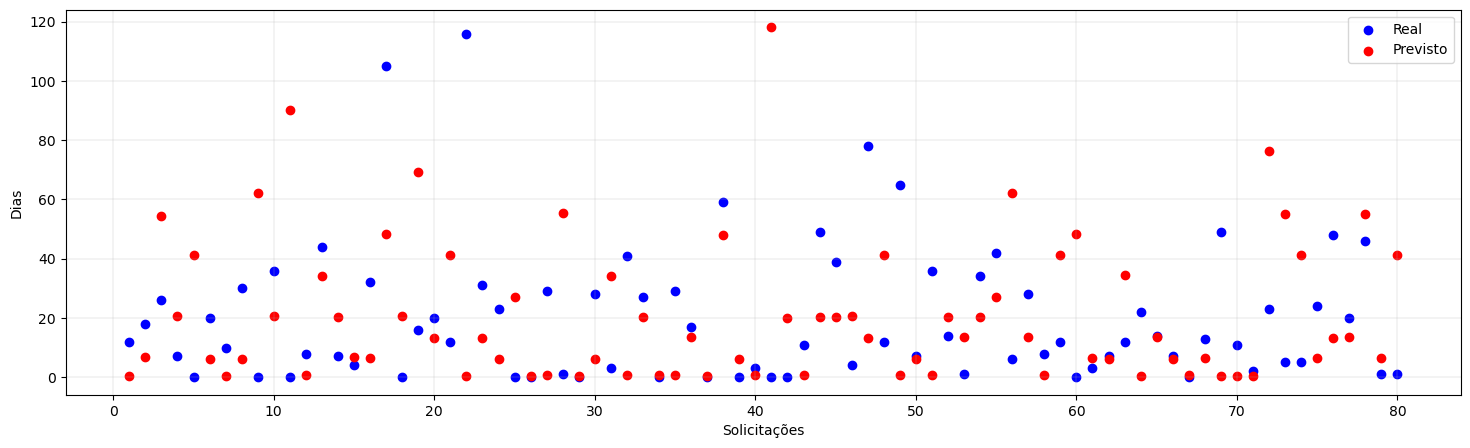

In [120]:
# Selecionar aleatoriamente 80 registros previstos
index_aleatorios = np.random.choice(len(y_previsto), size=80, replace=False)
real = y_treino.values[index_aleatorios]
previsto = y_previsto[index_aleatorios]

# Plotar o gráfico de dispersão
x = np.arange(1, 81)
fig, ax = plt.subplots(figsize=(18,5))
ax.scatter(x, real, color='b', label='Real')
ax.scatter(x, previsto, color='r', label='Previsto')
ax.grid(True, linewidth=0.2)
ax.set_xlabel('Solicitações')
ax.set_ylabel('Dias')
ax.legend()
plt.show()

# Importância relativa variáveis
Foi verificado a importância relativa das variáveis independentes do modelo utilizando o Random Forest.   
A coluna `M` corresponde ao gênero do paciente.

0 - procedimento: 0.05606
1 - cid: 0.0003
2 - idade_paciente: 0.00034
3 - municipio_residencia_paciente: 0.00058
4 - data_solicitacao_semana: 0.51775
5 - data_solicitacao_dia: 0.02355
6 - data_autorizacao_ano: 0.02123
7 - data_autorizacao_semana: 0.3569
8 - data_autorizacao_dia: 0.02307
9 - competencia_dispensacao_ano: 1e-05
10 - competencia_dispensacao_mes: 0.00015
11 - M: 6e-05


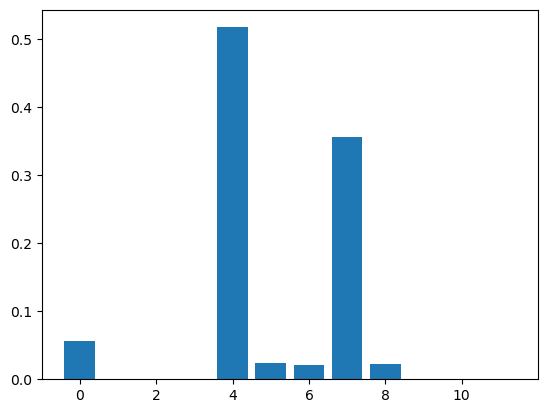

In [99]:
# Criar um novo modelo de Random Forest com os mesmos parâmetros
rf = RandomForestRegressor(max_depth = None, n_estimators = 100, random_state = 1)

# Treinar o modelo
rf.fit(X, y)

# Obter a importância relativa de cada variável
importancia = rf.feature_importances_

# Listar a importância
for i, v in enumerate(importancia):
    print(f"{i} - {X.columns[i]}: {round(v,5)}")

# Plotar a importância
plt.bar([x for x in range(len(importancia))], importancia)
plt.show()